Now, it’s time to install the necessary dependencies to run the RAG pipeline. Here, we are using pypdf library to read the PDF documents and sentence-transformers library to load the embedding generator and Reranker from hugging face:

In [1]:
!pip install -q pypdf
!pip install torch
!pip install -q transformers
!pip -q install sentence-transformers
!pip install -q llama-index
!pip install -q llama-index-llms-llama-cpp
!pip install llama-index-embeddings-huggingface
!pip install llama-index-llms-groq


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.4 MB/s eta 0:00:00
  Installing build 

Let’s configure the **GPU** for **llama-cpp-python**. llama-cpp-python is a Python binding for llama.cpp. It supports inference for many LLM models, which can be accessed on Hugging Face

In [2]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install  llama-cpp-python --no-cache-dir


Let’s load our large language model. I have already mentioned that we are going to use a `4-bit quantized LLM `for this demo. It is recommended to use a system having **at least 12 GB GPU and 16 GB RAM** for this application otherwise your system may not work as expected. Here, we loaded a quantized version of **Mistral-7B** from huggingface using **LlamaCPP** method provided by llama_index.

In [3]:
import torch

from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.llms.llama_cpp.llama_utils import messages_to_prompt, completion_to_prompt

llm = LlamaCPP(
    # You can pass in the URL to a GGML model to download it automatically
    # model_url='https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf',
    model_url='https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf',
    # optionally, you can set the path to a pre-downloaded model instead of model_url
    model_path=None,
    temperature=0.1,
    max_new_tokens=256,
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=4096,
    # kwargs to pass to __call__()
    generate_kwargs={},
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU
    model_kwargs={"n_gpu_layers": -1},
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)

total size (MB): 4368.44


4167it [00:28, 143.73it/s]                         
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /tmp/llama_index/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_

Now, it’s time to load the document using **SimpleDiretoryReader** from llama_index framework. Here, we concatenate each page of documents because SimpleDirectoryReader split the document into pages and load each page as a document. Here, I am using a research paper on LLM: A Survey of Large Language Models. You can download the paper from here. This paper provides an up-to-date review of the literature on LLMs.



Let’s read the document from the directory, concatenate each page of the document into a single object provided by the Llama_index Document class. The type of document object is **llama_index.schema.Document** .

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core import Document

documents = SimpleDirectoryReader(
    input_files = ["/content/drive/MyDrive/survey_on_llms.pdf"]
).load_data()

documents = Document(text = "\n\n".join([doc.text for doc in documents]))

Great, we have loaded the model and read the document. Now, let’s write the function to create the index from the document. In this step, we split the texts into sentence chunks and stored the embedding of the chunks to the vector index. Here, we are using huggingface `bge-small-en-v1.5` model for the embedding generation and we store the embeddings in the VectorStoreIndex provided by LlamaIndex.

For this tutorial, we are going to use the **Sentence Window Retrieval** technique. In this method, we retrieve based on smaller sentences to get a better match for the relevant context and then synthesize based on the expanded context window around the sentence.



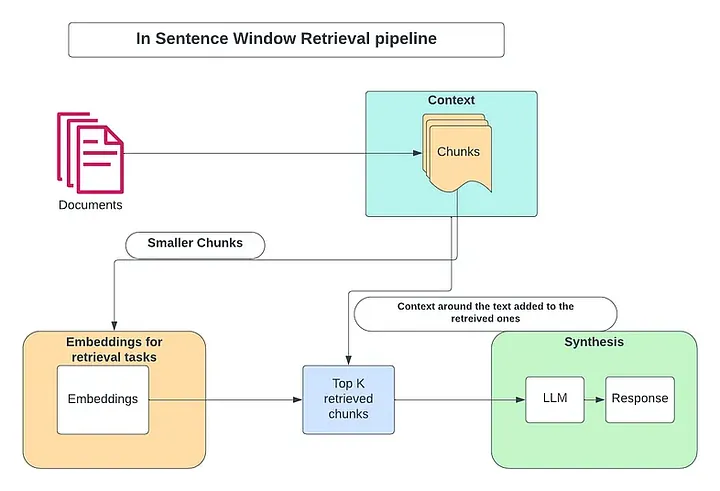

Here, We first embed smaller sentence chunks and store them in a vector database. We also add the context of sentences that occur before and after each sentence chunk. During retrieval, we retrieve the sentences that are more relevant to the query with the help of similarity search and then replace them with the full surrounding context`. sentence_window_size `parameter helps to define the size of sentences before and after the given sentence that we want to add during the retrieval.

In [8]:
import os
from llama_index.core.node_parser import SentenceWindowNodeParser
from llama_index.core import VectorStoreIndex, ServiceContext, load_index_from_storage, StorageContext

def get_build_index(documents,llm,embed_model="local:BAAI/bge-small-en-v1.5",sentence_window_size=3,save_dir="./vector_store/index"):

  node_parser = SentenceWindowNodeParser(
      window_size = sentence_window_size,
      window_metadata_key = "window",
      original_text_metadata_key = "original_text"
  )

  sentence_context = ServiceContext.from_defaults(
      llm = llm,
      embed_model= embed_model,
      node_parser = node_parser,
  )

  if not os.path.exists(save_dir):
        # create and load the index
        index = VectorStoreIndex.from_documents(
            [documents], service_context=sentence_context
        )
        index.storage_context.persist(persist_dir=save_dir)
  else:
      # load the existing index
      index = load_index_from_storage(
          StorageContext.from_defaults(persist_dir=save_dir),
          service_context=sentence_context,
      )

  return index

We have defined the function above to create the index store for the document. Now, let’s call the function to create a vector index:

In [9]:
# get the vector index
vector_index = get_build_index(documents=documents, llm=llm, embed_model="local:BAAI/bge-small-en-v1.5", sentence_window_size=3, save_dir="./vector_store/index")

<ipython-input-8-514fd297d787>:13: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  sentence_context = ServiceContext.from_defaults(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now, it’s time to write a function that will create the query engine for the newly created vector index. We can query our document using that query engine.

In [10]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor, SentenceTransformerRerank
def get_query_engine(sentence_index, similarity_top_k=3, rerank_top_n=2):
  postproc = MetadataReplacementPostProcessor(target_metadata_key="window")
  rerank = SentenceTransformerRerank(
      top_n=rerank_top_n, model="BAAI/bge-reranker-base"
  )
  engine = sentence_index.as_query_engine(
        similarity_top_k=similarity_top_k, node_postprocessors=[postproc, rerank]
  )

  return engine

Ok, we have defined the function to create the query engine. Let’s create the query engine by calling the get_query_engine() function recently defined.

In [11]:
query_engine = get_query_engine(sentence_index=vector_index, similarity_top_k=3, rerank_top_n=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Here, we have created the query engine as well. So, our RAG pipeline is completely ready and the query engine is now ready to respond to our query. Let’s do queries on the document:



In [13]:
response = query_engine.query("What is a large language model?")
response

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =  217013.02 ms
llama_print_timings:      sample time =      82.72 ms /   136 runs   (    0.61 ms per token,  1644.06 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   90970.83 ms /   136 runs   (  668.90 ms per token,     1.49 tokens per second)
llama_print_timings:       total time =   91171.42 ms /   136 tokens


Response(response=' A large language model (LLM) refers to Transformer language models that contain hundreds of billions or more parameters, trained on massive text data. These models exhibit strong capacities to understand natural language and solve complex tasks through text generation. LLMs have shown significant performance improvements over smaller models and exhibit emergent abilities such as in-context learning. The term "large language model" was coined to distinguish these models from smaller pre-trained language models (PLMs). Recent advances in LLMs have led to the development of powerful AI chatbots like ChatGPT, which has attracted widespread attention from society and is making an important impact on the entire AI community.', source_nodes=[NodeWithScore(node=TextNode(id_='701a87da-bd56-479f-bd3e-9f2f7f3711e9', embedding=None, metadata={'window': 'Then, Sec-\ntion 8 discusses the practical guide for prompt design,\nand Section 9 reviews the applications of LLMs in several

In [14]:
response = query_engine.query("What are currently available open-source llm’s?")
response

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =  217013.02 ms
llama_print_timings:      sample time =     166.62 ms /   255 runs   (    0.65 ms per token,  1530.44 tokens per second)
llama_print_timings: prompt eval time =  264003.00 ms /   613 tokens (  430.67 ms per token,     2.32 tokens per second)
llama_print_timings:        eval time =  167441.80 ms /   254 runs   (  659.22 ms per token,     1.52 tokens per second)
llama_print_timings:       total time =  431889.84 ms /   867 tokens


Response(response=" Based on the context provided, there are several open-source language models (LLMs) mentioned, including LLaVA [149], MiniGPT-4 [150], InstructBLIP [151], and PandaGPT [152]. However, it's important to note that the availability of these models as open-source may vary, and I cannot confirm their current availability without checking their respective repositories or official websites.\n\nAdditionally, OpenAI provides APIs for several models in the GPT-series (ada, babbage, curie, davinci, text-ada-001, text-babbage-001, and text-curie-001), which can be used as a more convenient way for common users to access these models without running them locally.\n\nAnother approach mentioned in the context is GPS [469], which uses a language model (T5) for prompt editing, but it's not clear if this specific implementation is open-source or not.\n\nTherefore, I would recommend checking the official websites or repositories of these models to confirm their current availability an

the response is very long, so i will summerize it using **BART** model

We can summarize using Large Language Models. Let’s summarize a long text describing large language models using the **Bart Large CNN model.** :

In [25]:
response = ("""
Response(response=" Based on the context provided, there are several open-source language models (LLMs) mentioned, including LLaVA [149], MiniGPT-4 [150], InstructBLIP [151], and PandaGPT [152]. However, it's important to note that the availability of these models as open-source may vary, and I cannot confirm their current availability without checking their respective repositories or official websites.\n\nAdditionally, OpenAI provides APIs for several models in the GPT-series (ada, babbage, curie, davinci, text-ada-001, text-babbage-001, and text-curie-001), which can be used as a more convenient way for common users to access these models without running them locally.\n\nAnother approach mentioned in the context is GPS [469], which uses a language model (T5) for prompt editing, but it's not clear if this specific implementation is open-source or not.\n\nTherefore, I would recommend checking the official websites or repositories of these models to confirm their current availability and open-source status.", source_nodes=[NodeWithScore(node=TextNode(id_='0cf1ec55-8968-45af-8dd3-305a5548e9e6', embedding=None, metadata={'window': 'Compared\nwith other variants, Vicuna is more preferred in multimodal\n\n13\nlanguage models, which have led to the emergence of a va-\nriety of popular models, including LLaVA [149], MiniGPT-\n4 [150], InstructBLIP [151], and PandaGPT [152].  The re-\nlease of LLaMA has greatly advanced the research progress\nof LLMs.  To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n Public API of LLMs .  Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally.  As a representative interface for using LLMs, the\nAPIs for the GPT-series models [46, 55, 66, 105] have\nbeen widely used for both academia and industry19.\n OpenAI has provided seven major interfaces to the models\nin GPT-3 series: ada,babbage ,curie ,davinci (the\nmost powerful version in GPT-3 series), text-ada-001 ,\ntext-babbage-001 , and text-curie-001 . ', 'original_text': 'Public API of LLMs . '}, excluded_embed_metadata_keys=['window', 'original_text'], excluded_llm_metadata_keys=['window', 'original_text'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6bf057d9-c457-4c9e-8181-434fdcb98627', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='ce67a7ed62af798e6bd83b6a9311fbf5ca1687238a98677786a1362909dfbd03'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='66c1ae75-9788-4dda-a7dc-6b5bd3add535', node_type=<ObjectType.TEXT: '1'>, metadata={'window': 'Due to the excellent performance and availability of the\nLLaMA model family, many multimodal models incorpo-\nrate them as the base language models, to achieve strong\nlanguage understanding and generation abilities.  Compared\nwith other variants, Vicuna is more preferred in multimodal\n\n13\nlanguage models, which have led to the emergence of a va-\nriety of popular models, including LLaVA [149], MiniGPT-\n4 [150], InstructBLIP [151], and PandaGPT [152].  The re-\nlease of LLaMA has greatly advanced the research progress\nof LLMs.  To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n Public API of LLMs .  Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally.  As a representative interface for using LLMs, the\nAPIs for the GPT-series models [46, 55, 66, 105] have\nbeen widely used for both academia and industry19.\n', 'original_text': 'To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n'}, hash='e053f71bd1b64c616aa580c400d28942a71371cf083fd6c7575f335774d09e04'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='39b68d98-48f9-4d49-a4f8-14323a6447b5', node_type=<ObjectType.TEXT: '1'>, metadata={'window': 'The re-\nlease of LLaMA has greatly advanced the research progress\nof LLMs.  To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n Public API of LLMs .  Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally.  As a representative interface for using LLMs, the\nAPIs for the GPT-series models [46, 55, 66, 105] have\nbeen widely used for both academia and industry19.\n OpenAI has provided seven major interfaces to the models\nin GPT-3 series: ada,babbage ,curie ,davinci (the\nmost powerful version in GPT-3 series), text-ada-001 ,\ntext-babbage-001 , and text-curie-001 .  Among\nthem, the first four interfaces can be further fine-\ntuned on the host server of OpenAI. ', 'original_text': 'Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally. '}, hash='4c3488507df6de11dc76d9a3387a498cb5b257f5ef29aa1fb75c8df481d05593')}, text='Compared\nwith other variants, Vicuna is more preferred in multimodal\n\n13\nlanguage models, which have led to the emergence of a va-\nriety of popular models, including LLaVA [149], MiniGPT-\n4 [150], InstructBLIP [151], and PandaGPT [152].  The re-\nlease of LLaMA has greatly advanced the research progress\nof LLMs.  To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n Public API of LLMs .  Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally.  As a representative interface for using LLMs, the\nAPIs for the GPT-series models [46, 55, 66, 105] have\nbeen widely used for both academia and industry19.\n OpenAI has provided seven major interfaces to the models\nin GPT-3 series: ada,babbage ,curie ,davinci (the\nmost powerful version in GPT-3 series), text-ada-001 ,\ntext-babbage-001 , and text-curie-001 . ', start_char_idx=73763, end_char_idx=73784, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.004626421), NodeWithScore(node=TextNode(id_='af490f32-61ea-425e-aafa-f4630b3764d3', embedding=None, metadata={'window': 'Specifically, GPS [469] bor-\nrows an idea from the genetic algorithm and proposes\na genetic prompt search method that utilizes a language\nmodel ( i.e.,T5) to edit prompts by taking the cloze task form.\n In addition to model based edit methods, human-defined\noperations can be also employed for prompt editing [470],\nincluding delete, swap, paraphrase, and addition.  Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n •LLM-based approaches.  Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473].  Specifically, APE [471]\nutilizes an LLM to generate initial prompts, then selects\nthe best prompt with the highest accuracy, and finally im-\nproves the best candidate through an iterative Monte Carlo\nsearch method.  Similarly, APO [472] instructs the LLM to\ngenerate text feedback on how to refine an old prompt\ninto new improved prompts. ', 'original_text': '•LLM-based approaches. '}, excluded_embed_metadata_keys=['window', 'original_text'], excluded_llm_metadata_keys=['window', 'original_text'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6bf057d9-c457-4c9e-8181-434fdcb98627', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='ce67a7ed62af798e6bd83b6a9311fbf5ca1687238a98677786a1362909dfbd03'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='2cd0d781-3978-4992-aa4c-5f7bbb143e0d', node_type=<ObjectType.TEXT: '1'>, metadata={'window': 'Therefore,\nanother line of work aims to directly edit existing prompts\nbased on the task performance.  Specifically, GPS [469] bor-\nrows an idea from the genetic algorithm and proposes\na genetic prompt search method that utilizes a language\nmodel ( i.e.,T5) to edit prompts by taking the cloze task form.\n In addition to model based edit methods, human-defined\noperations can be also employed for prompt editing [470],\nincluding delete, swap, paraphrase, and addition.  Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n •LLM-based approaches.  Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473].  Specifically, APE [471]\nutilizes an LLM to generate initial prompts, then selects\nthe best prompt with the highest accuracy, and finally im-\nproves the best candidate through an iterative Monte Carlo\nsearch method. ', 'original_text': 'Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n'}, hash='f97b5b7d5244a5d865cc7dad3f63b5c5bfea1bb8e760bb5914be39a76f56e9a1'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='5288394a-061b-4888-a661-3bcca0b8fec1', node_type=<ObjectType.TEXT: '1'>, metadata={'window': 'In addition to model based edit methods, human-defined\noperations can be also employed for prompt editing [470],\nincluding delete, swap, paraphrase, and addition.  Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n •LLM-based approaches.  Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473].  Specifically, APE [471]\nutilizes an LLM to generate initial prompts, then selects\nthe best prompt with the highest accuracy, and finally im-\nproves the best candidate through an iterative Monte Carlo\nsearch method.  Similarly, APO [472] instructs the LLM to\ngenerate text feedback on how to refine an old prompt\ninto new improved prompts.  However, their search in the\nprompt space might be inefficient without fully considering\nthe whole refinement trace of previous prompts, thus po-\ntentially leading to sub-optimal results. ', 'original_text': 'Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473]. '}, hash='1a11a24b7bcc48efc8e9e1eaa5a55b1df45cc8ad62eca57232688c143c61e3c5')}, text='Specifically, GPS [469] bor-\nrows an idea from the genetic algorithm and proposes\na genetic prompt search method that utilizes a language\nmodel ( i.e.,T5) to edit prompts by taking the cloze task form.\n In addition to model based edit methods, human-defined\noperations can be also employed for prompt editing [470],\nincluding delete, swap, paraphrase, and addition.  Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n •LLM-based approaches.  Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473].  Specifically, APE [471]\nutilizes an LLM to generate initial prompts, then selects\nthe best prompt with the highest accuracy, and finally im-\nproves the best candidate through an iterative Monte Carlo\nsearch method.  Similarly, APO [472] instructs the LLM to\ngenerate text feedback on how to refine an old prompt\ninto new improved prompts. ', start_char_idx=311086, end_char_idx=311109, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.001403947)], metadata={'0cf1ec55-8968-45af-8dd3-305a5548e9e6': {'window': 'Compared\nwith other variants, Vicuna is more preferred in multimodal\n\n13\nlanguage models, which have led to the emergence of a va-\nriety of popular models, including LLaVA [149], MiniGPT-\n4 [150], InstructBLIP [151], and PandaGPT [152].  The re-\nlease of LLaMA has greatly advanced the research progress\nof LLMs.  To summarize the research work conducted on\nLLaMA, we present a brief evolutionary graph in Figure 5.\n Public API of LLMs .  Instead of directly using the model\ncopies, APIs provide a more convenient way for common\nusers to use LLMs, without the need of running the model\nlocally.  As a representative interface for using LLMs, the\nAPIs for the GPT-series models [46, 55, 66, 105] have\nbeen widely used for both academia and industry19.\n OpenAI has provided seven major interfaces to the models\nin GPT-3 series: ada,babbage ,curie ,davinci (the\nmost powerful version in GPT-3 series), text-ada-001 ,\ntext-babbage-001 , and text-curie-001 . ', 'original_text': 'Public API of LLMs . '}, 'af490f32-61ea-425e-aafa-f4630b3764d3': {'window': 'Specifically, GPS [469] bor-\nrows an idea from the genetic algorithm and proposes\na genetic prompt search method that utilizes a language\nmodel ( i.e.,T5) to edit prompts by taking the cloze task form.\n In addition to model based edit methods, human-defined\noperations can be also employed for prompt editing [470],\nincluding delete, swap, paraphrase, and addition.  Based\non these operations, they iteratively edit the prompts and\ngreedily search for the best prompt guided by the model\nperformance on a small pool of examples.\n •LLM-based approaches.  Due to the exceptional capacities\nof LLMs, an increasing number of studies directly leverage\nLLMs as prompt generator [471–473].  Specifically, APE [471]\nutilizes an LLM to generate initial prompts, then selects\nthe best prompt with the highest accuracy, and finally im-\nproves the best candidate through an iterative Monte Carlo\nsearch method.  Similarly, APO [472] instructs the LLM to\ngenerate text feedback on how to refine an old prompt\ninto new improved prompts. ', 'original_text': '•LLM-based approaches. '}})""")


In [41]:
from transformers import BartForConditionalGeneration, BartTokenizer
import textwrap

model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

inputs = tokenizer.encode("summarize: " + response, return_tensors="pt", max_length=1024, truncation=True)
summary_ids = model.generate(inputs, max_length=250, min_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
formatted_summary = "\n".join(textwrap.wrap(summary, width=80))
formatted_summary

'There are several open-source language models (LLMs) mentioned, including LLaVA,\nMiniGPT-4, InstructBLIP, and PandaGPT. OpenAI provides APIs for several models\nin the GPT-series (ada, babbage, curie, davinci, text-ada-001, and text-\ncurie-001), which can be used as a more convenient way for common users to\naccess these models without running them locally. The re-lease of LLaMA has\ngreatly advanced the research progress of LLMs. Compared with other variants,\nVicuna is more preferred in multimodal.language models, which have led to the\nemergence of a va- grotesque variety of popular models, including\xa0LLaVA [149]\nand\xa0PandaGPT [152].'